# MILP Clustering - USA Single site

In [1]:
import numpy as np
import pandas as pd

from scipy.spatial import distance as spd

from pyomo import environ as pe
glpk_path='~/AppData/Local/Continuum/Anaconda3/pkgs/glpk-4.63-vc14_0/Library/bin/glpsol.exe'

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import k_medoids_milp as clustering
import clustering_utils as utils

### generate sample data

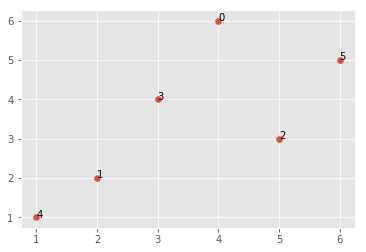

In [3]:
n_points = 365
n_clusters = 6

# get cluster center positions
clusters = np.arange(n_clusters)
clusters_x = np.arange(1, n_clusters+1)
clusters_y = np.arange(1, n_clusters+1)
np.random.shuffle(clusters_x)
np.random.shuffle(clusters_y)

fig, ax = plt.subplots()
ax.scatter(clusters_x, clusters_y);

for k, coords in enumerate(zip(clusters_x, clusters_y)):
    ax.annotate(str(k), coords)

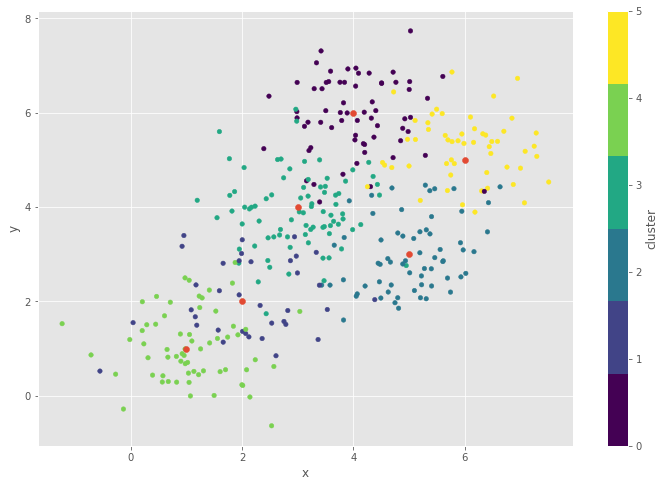

In [4]:
# randomly assign each point to a cluster
cluster_id = np.random.choice(clusters, size=n_points)

# get dictionary like k : array of indices of elements belonging to cluster k
cluster_members = {k:np.where(cluster_id == k)[0] for k in clusters}

# initialize dataframe
df = pd.DataFrame({'cluster': cluster_id}, columns=['cluster', 'x', 'y'])

# set coordinates as centers of each cluster
df[['x', 'y']] = [(clusters_x[k], clusters_y[k]) for k in cluster_id]

# add noise
df[['x', 'y']] += np.random.normal(scale=0.75, size=(n_points,2))

cmap = plt.get_cmap('viridis', n_clusters)
### plot
fig, ax = plt.subplots(figsize=(12,8))
df.plot.scatter(x='x', y='y', c='cluster', cmap=cmap, ax=ax)

ax.scatter(clusters_x, clusters_y);

ax.xaxis.set_visible(True)

### prepare model input

In [5]:
### get distance matrix
distance_matrix = spd.squareform(spd.pdist(df[['x', 'y']].values))
distance_matrix = np.around(distance_matrix, decimals=3)

dist_df = pd.DataFrame(
    distance_matrix, 
    index = np.arange(1, n_points+1),
    columns = np.arange(1, n_points+1)
)

In [6]:
data = dict(
    n_days = n_points,
    n_clusters = n_clusters,
    n_extreme_days = 0,
    distance = dist_df.stack().to_dict()
)

data = utils.get_pyomo_input_dictionary(data)

### solve

In [8]:
m = clustering.create_model()

cm = m.create_instance(data=data)

with pe.SolverFactory('glpk', executable=glpk_path) as opt:
    
    # solve
    results = opt.solve(cm)
    
cm.solutions.load_from(results)

In [9]:
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 307.259
  Upper bound: 307.259
  Number of objectives: 1
  Number of constraints: 133593
  Number of variables: 133591
  Number of nonzeros: 533266
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 246.76016759872437
# ----------------------------------------------------------
#   Solution Information
# -------------------

### extract results

In [10]:
y = pd.Series(cm.y.get_values())
z = pd.Series(cm.z.get_values()).unstack()

labeled = z.iloc[np.where(y>0)[0],:].mul(np.arange(n_clusters), axis=0).sum()

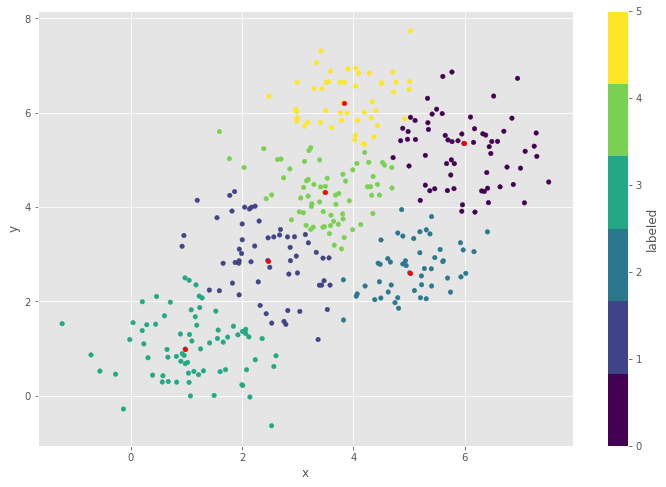

In [11]:
df['labeled'] = labeled.values


### plot

cmap = plt.get_cmap('viridis', n_clusters)

fig, ax = plt.subplots(figsize=(12,8))
df.plot.scatter(x='x', y='y', c='labeled', cmap=cmap, ax=ax)

df.iloc[np.where(y>0)[0]].plot.scatter(x='x', y='y', color='r', ax=ax);

ax.xaxis.set_visible(True)

### Solving with NEOS server

In [12]:
with pe.SolverFactory("cplex") as opt:

    # opt.options['absmipgap'] = 0.1

    solver_manager = pe.SolverManagerFactory('neos')

    results = solver_manager.solve(cm, opt=opt)

Job 6090127 submitted to NEOS, password='GEbODWxX'
Check the following URL for progress report :
https://www.neos-server.org/neos/cgi-bin/nph-neos-solver.cgi?admin=results&jobnumber=6090127&pass=GEbODWxX
Job 6090127 dispatched
password: GEbODWxX
---------- Begin Solver Output -----------
Condor submit: 'neos.submit'
Condor submit: 'watchdog.submit'
Job submitted to NEOS HTCondor pool.


In [13]:
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 133590
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CPLEX 12.7.0.0\x3a optimal integer solution; objective 307.2589999999999; 38 MIP simplex iterations; 0 branch-and-bound nodes; No basis.
  Termination condition: optimal
  Id: 2
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number